# CNS Laboratory 3.2

Author: Luca Moroni

In [ ]:
# create the folder in which i will save the stuffs
# images folder
!mkdir Images

# saved object folder
!mkdir Objects

mkdir: cannot create directory ‘Images’: File exists
mkdir: cannot create directory ‘Objects’: File exists


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import figure
import itertools
import random

Function definitions

In [ ]:
def active_reproducibility(manual_seed=42):
    """
      Function that set random seeds for every used library.
    """

    random.seed(manual_seed)
    np.random.seed(manual_seed)


def multiple_eval(model_args, X_train, y_train, X_valid, y_valid, num_trials=5):

    train_loss = 0
    valid_loss = 0

    for i in range(num_trials):
        esn = EchoStateNetwork(1, **model_args)
        
        esn.train(X_train, y_train)

        _, h_train = esn.predict(X_train)

        tr_loss, h_train = esn.evaluate(X_train, y_train)
        vl_loss, _ = esn.evaluate(X_valid, y_valid, h_train)

        train_loss += tr_loss
        valid_loss += vl_loss

    return train_loss/num_trials, valid_loss/num_trials


def grid_search(grid, X_train, y_train, X_valid, y_valid):
    """
    Grid search the best parameters of the model, the parameters are get out from
    the grid dictionary, iterating over all the possible combination of the values
    in it.
    """
    
    best_valid_loss = np.inf
    best_params = None
    best_train_loss = None
    
    for args_comb in itertools.product(*grid.values()):

        train_args = {k:v for (k, v) in zip(list(grid.keys()), args_comb)}

        train_loss, valid_loss = multiple_eval(train_args, X_train, y_train, X_valid, y_valid)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = train_args
            best_train_loss = train_loss

        print(" -- finished", train_args, "train loss", train_loss,"valid loss", valid_loss)
            
    print("finished grid search, the best are:", best_params, "with a loss of: ", best_valid_loss)
        
    return best_train_loss, best_valid_loss, best_params

Echo State Network

In [ ]:
class EchoStateNetwork():
  def __init__(self, input_dim=1, hidden_dim=10, spectral_radius=0.5, delta_x=0.4, delta_b=0.4, transient_lenght=10, lambda_reg=0):
    self.input_dim = input_dim

    # input weights, generate random matrix whose values lies in [-delta_x, delta_x]
    self.W_x = (np.random.rand(input_dim, hidden_dim)*2 - 1)*delta_x

    # input bias, generate random vector whose values lies in [-delta_b, delta_b]
    self.b = (np.random.rand(hidden_dim)*2 - 1)*delta_b

    # initialization of the recurrent weight matrix
    self.W_h = np.random.rand(hidden_dim, hidden_dim)*2 - 1 # values in [-1, 1]
    # get the spectrum
    spectrum = np.max(np.abs(np.linalg.eigvals(self.W_h)))

    self.W_h = (self.W_h/spectrum) * spectral_radius # adjust the spectral radius

    self.transient_lenght = transient_lenght
    self.hidden_dim = hidden_dim

    self.lambda_reg = lambda_reg

    self.W_o = None

  def _compute_hidden_states(self, data, hidden_state, training):
    hidden_states = []

    for i, data_i in enumerate(data):
      hidden_state = np.tanh(hidden_state@self.W_h + data_i@self.W_x + self.b)

      if i >= self.transient_lenght or not training:
        hidden_states.append(hidden_state.copy())
    
    hidden_states = np.array(hidden_states)

    # add bias
    hidden_states = np.concatenate([np.array(hidden_states), np.ones((hidden_states.shape[0], 1))], axis=1)

    return hidden_states


  def train(self, data, target):
    # compute the reservoir states
    hidden_state = np.zeros(self.hidden_dim)

    if len(data.shape) == 1:
      data = np.expand_dims(data, axis=1)

    if len(target.shape) == 1:
      target = np.expand_dims(target, axis=1)

    hidden_states = self._compute_hidden_states(data, hidden_state, True)

    # compute the readout
    self.W_o = target[self.transient_lenght:].T@hidden_states@np.linalg.inv(hidden_states.T@hidden_states + self.lambda_reg*np.eye(self.hidden_dim+1))

  def predict(self, data, hidden_state=None):

    if hidden_state is None:
      hidden_state = np.zeros(self.hidden_dim)

    to_squeeze = False

    if len(data.shape) == 1:
      to_squeeze = True
      data = np.expand_dims(data, axis=1)

    hidden_states = self._compute_hidden_states(data, hidden_state, False)

    output = hidden_states@self.W_o.T

    if to_squeeze:
      output = np.squeeze(output, 1)
    
    # return output and last hidden_state
    return output, hidden_states[-1, :-1] # remove bias 
    # return output, hidden_states[-1]

  def evaluate(self, data, target, hidden_state=None):
    pred, h_pred = self.predict(data, hidden_state)

    if hidden_state is None:
      pred = pred[self.transient_lenght:]
      target = target[self.transient_lenght:]

    return (np.square(pred - target)).mean(), h_pred

In [ ]:
active_reproducibility()

## NARMA10

In [ ]:
data_narma10 = pd.read_csv("NARMA10.csv", header=None)

In [ ]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [ ]:
NARMA10_X = data_narma10.values[0, :]
NARMA10_y = data_narma10.values[1, :]

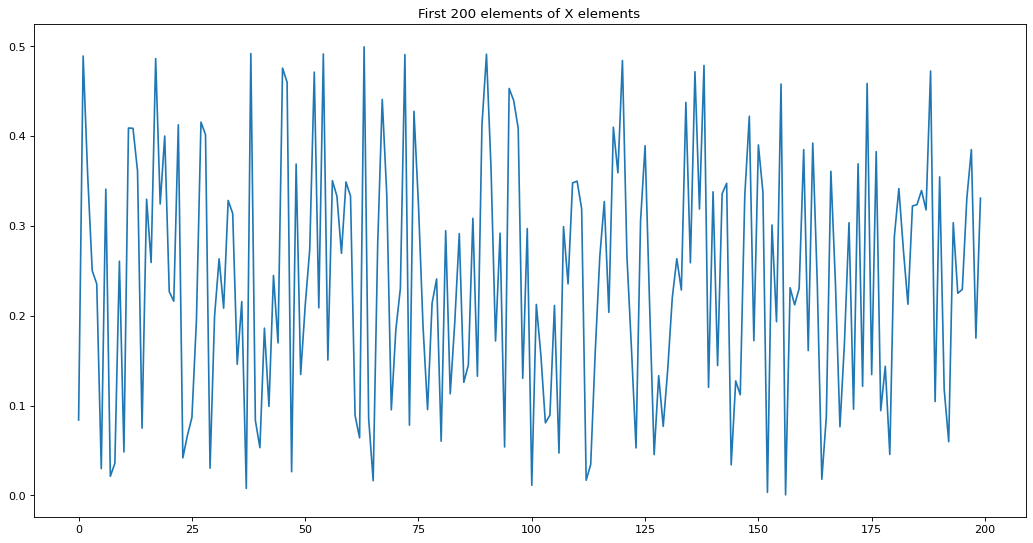

In [ ]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(NARMA10_X[:200])
plt.show()

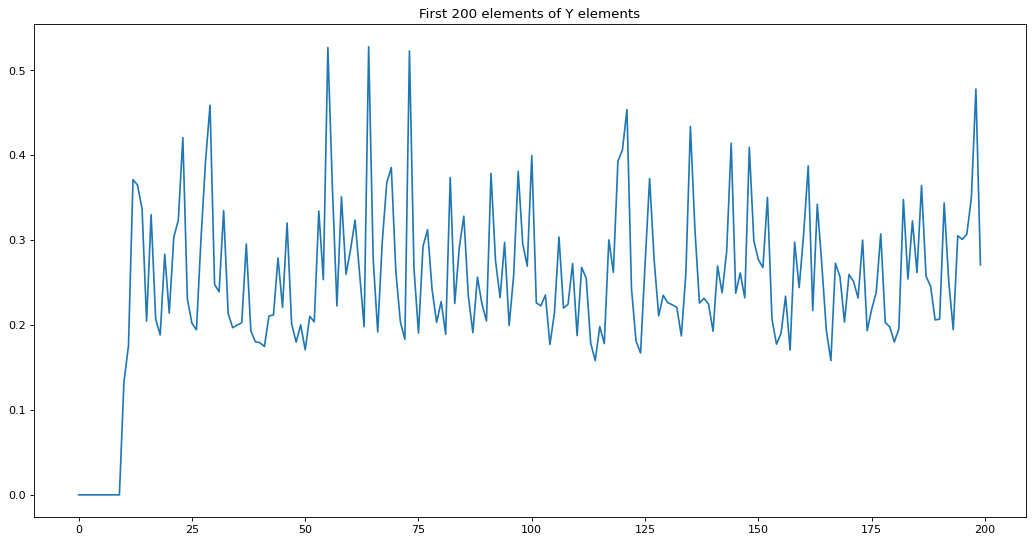

In [ ]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(NARMA10_y[:200])
plt.show()

In [ ]:
# train split
X_train = NARMA10_X[:4000]
y_train = NARMA10_y[:4000]

# valid split
X_valid = NARMA10_X[4000:5000]
y_valid = NARMA10_y[4000:5000]

In [ ]:
grid = {
    "hidden_dim" : [10, 100],
    "spectral_radius" : [0.3, 0.9],
    "delta_x" : [0.1, 0.5],
    "delta_b" : [0.1, 0.5],
    "transient_lenght" : [100],
    "lambda_reg" : [0, 0.01]
}

train_loss, valid_loss, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 0.00440205931815837 valid loss 0.00448502927084633
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.004478709456789418 valid loss 0.004536566189319871
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0} train loss 0.004397548181931137 valid loss 0.0044957608829840805
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.00452427693922862 valid loss 0.004592705126479186
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.5, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 0.004394403627481519 valid loss 0.00450197056414495
 -- finished {'hidden_dim':

In [ ]:
NARMA10_TDNN_valid_loss = valid_loss

In [ ]:
# test split
X_test = NARMA10_X[5000:]
y_test = NARMA10_y[5000:]

# train split
X_train = NARMA10_X[:5000]
y_train = NARMA10_y[:5000]

In [ ]:
best_params

{'hidden_dim': 100,
 'spectral_radius': 0.9,
 'delta_x': 0.1,
 'delta_b': 0.5,
 'transient_lenght': 100,
 'lambda_reg': 0}

In [ ]:
# compute the average of train and test error
train_loss, test_loss = multiple_eval(best_params, X_train, y_train, X_test, y_test)

In [ ]:
NARMA10_TDNN_train_loss = train_loss
NARMA10_TDNN_test_loss = test_loss

In [ ]:
print("NARMA10 Losses")
print("-- MSE Train", NARMA10_TDNN_train_loss)
print("-- MSE Valid", NARMA10_TDNN_valid_loss)
print("-- MSE Test", NARMA10_TDNN_test_loss)

NARMA10 Losses
-- MSE Train 0.00025559046426824097
-- MSE Valid 0.00024274927877693107
-- MSE Test 0.0002740582305081576


In [ ]:
esn = EchoStateNetwork(1, **best_params)
esn.train(X_train, y_train)

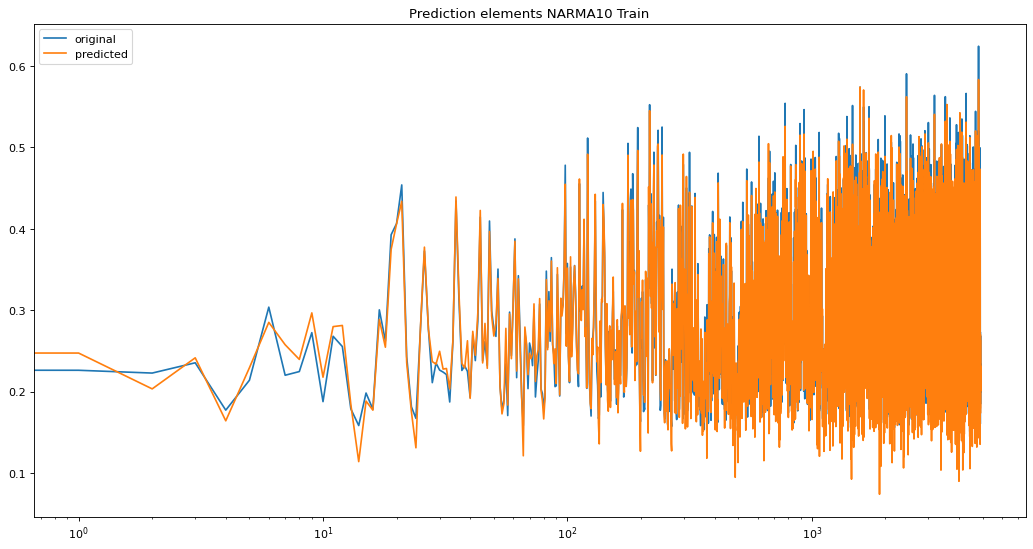

In [ ]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = esn.predict(NARMA10_X)
plt.title("Prediction elements NARMA10 Train")
plt.semilogx(NARMA10_y[100:5000], label="original") # remove the transient
plt.semilogx(y_pred[100:5000], label="predicted") # remove the transient
plt.legend()
plt.savefig("Images/NARMA10_Train_Pred")
plt.show()

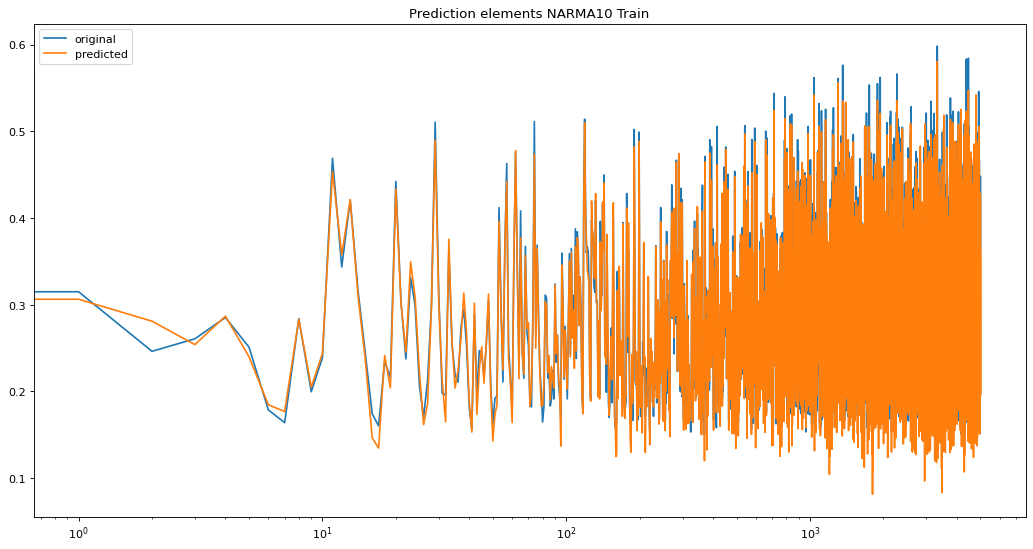

In [ ]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction elements NARMA10 Train")
plt.semilogx(NARMA10_y[5000:], label="original")
plt.semilogx(y_pred[5000:], label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_Test_Pred")
plt.show()

## MG-17

In [ ]:
data_mg17 = pd.read_csv("MG17.csv", header=None)

In [ ]:
data_mg17.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.032164,0.040426,0.057861,0.084015,0.11544,0.14572,0.16758,0.17624,0.17107,0.15465,...,-0.43905,-0.43957,-0.42772,-0.40213,-0.36305,-0.31286,-0.25555,-0.19556,-0.1368,-0.082192


In [ ]:
data = data_mg17.values[0, :]

MG17_X = data[:-1]
MG17_y = data[1:]

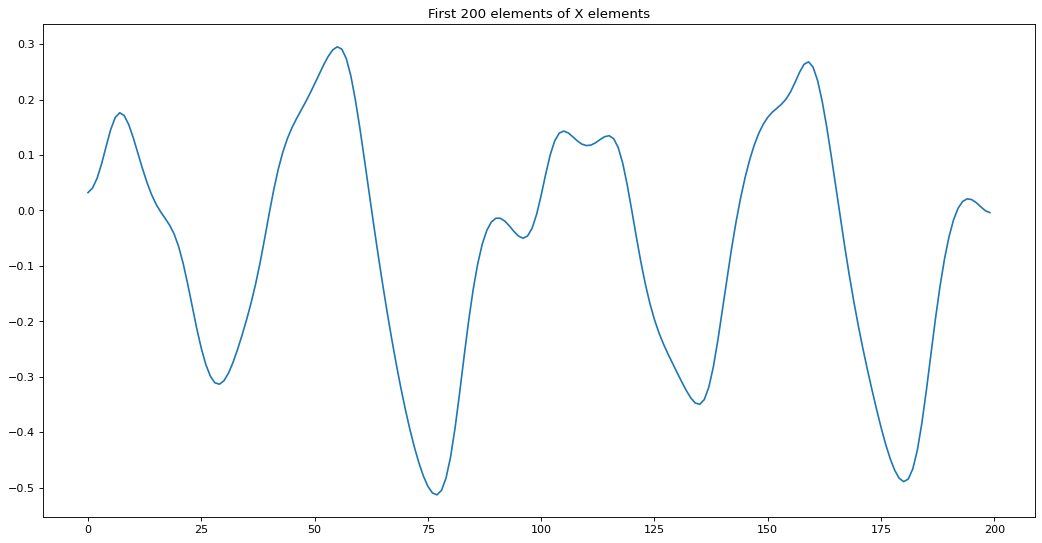

In [ ]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(MG17_X[:200])
plt.show()

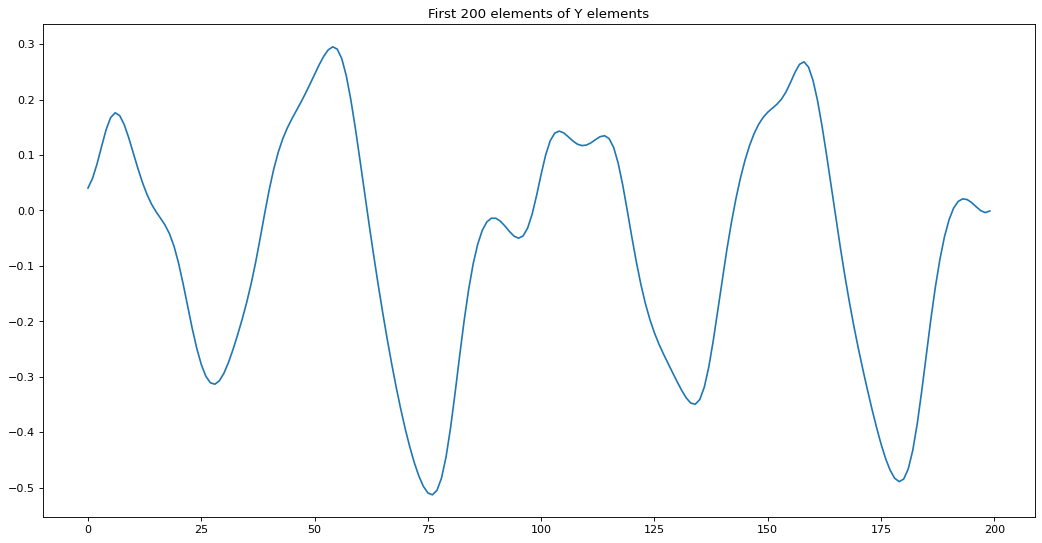

In [ ]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(MG17_y[:200])
plt.show()

In [ ]:
# train split
X_train = MG17_X[:4000]
y_train = MG17_y[:4000]

# valid split
X_valid = MG17_X[4000:5000]
y_valid = MG17_y[4000:5000]

In [ ]:
grid = {
    "hidden_dim" : [10, 100],
    "spectral_radius" : [0.3, 0.9],
    "delta_x" : [0.1, 0.5],
    "delta_b" : [0.1, 0.5],
    "transient_lenght" : [100],
    "lambda_reg" : [0, 0.01]
}

train_loss, valid_loss, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 2.3818377307676634e-07 valid loss 2.150338094098503e-07
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.000341117449940318 valid loss 0.00034451703121660864
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0} train loss 2.567883212765746e-06 valid loss 2.5364682635318727e-06
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.1, 'delta_b': 0.5, 'transient_lenght': 100, 'lambda_reg': 0.01} train loss 0.0003302417237664937 valid loss 0.0003335508801773807
 -- finished {'hidden_dim': 10, 'spectral_radius': 0.3, 'delta_x': 0.5, 'delta_b': 0.1, 'transient_lenght': 100, 'lambda_reg': 0} train loss 4.3172531100564e-07 valid loss 3.974503781387274e-07
 -- finished {

In [ ]:
MG17_valid_loss = valid_loss

In [ ]:
# test split
X_test = MG17_X[5000:]
y_test = MG17_y[5000:]

# train split
X_train = MG17_X[:5000]
y_train = MG17_y[:5000]

In [ ]:
best_params

{'hidden_dim': 100,
 'spectral_radius': 0.9,
 'delta_x': 0.5,
 'delta_b': 0.1,
 'transient_lenght': 100,
 'lambda_reg': 0}

In [ ]:
# compute the average of train and test error
train_loss, test_loss = multiple_eval(best_params, X_train, y_train, X_test, y_test)

In [ ]:
MG17_train_loss = train_loss
MG17_test_loss = test_loss

In [ ]:
print("MG17 Losses")
print("-- MSE Train", MG17_train_loss)
print("-- MSE Valid", MG17_valid_loss)
print("-- MSE Test", MG17_test_loss)

MG17 Losses
-- MSE Train 5.499794461918106e-08
-- MSE Valid 9.135955566607685e-09
-- MSE Test 5.5288563397901214e-08


In [ ]:
esn = EchoStateNetwork(1, **best_params)
esn.train(X_train, y_train)

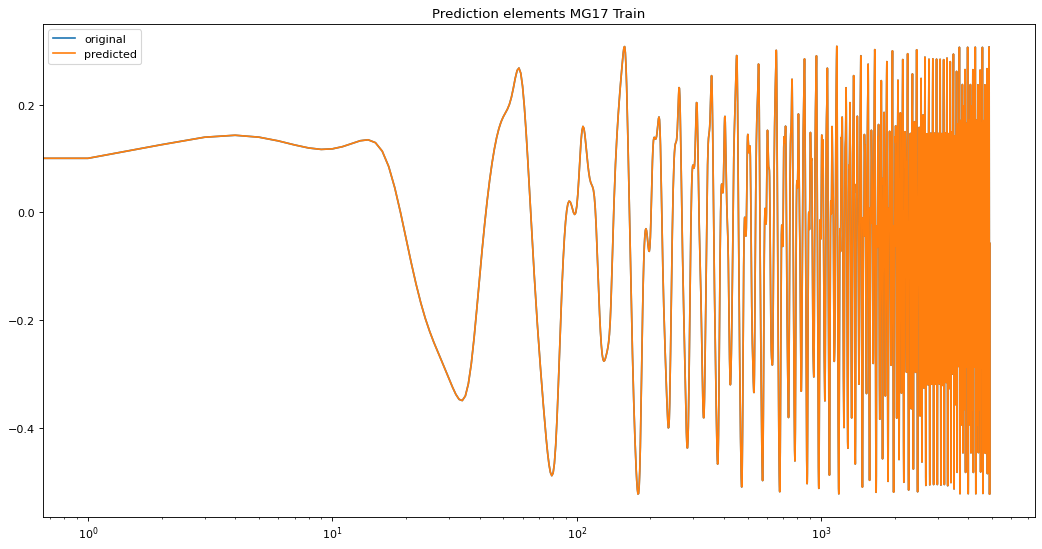

In [ ]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = esn.predict(MG17_X)
plt.title("Prediction elements MG17 Train")
plt.semilogx(MG17_y[100:5000], label="original") # remove the transient
plt.semilogx(y_pred[100:5000], label="predicted") # remove the transient
plt.legend()
plt.savefig("Images/MG17_Train_Pred")
plt.show()

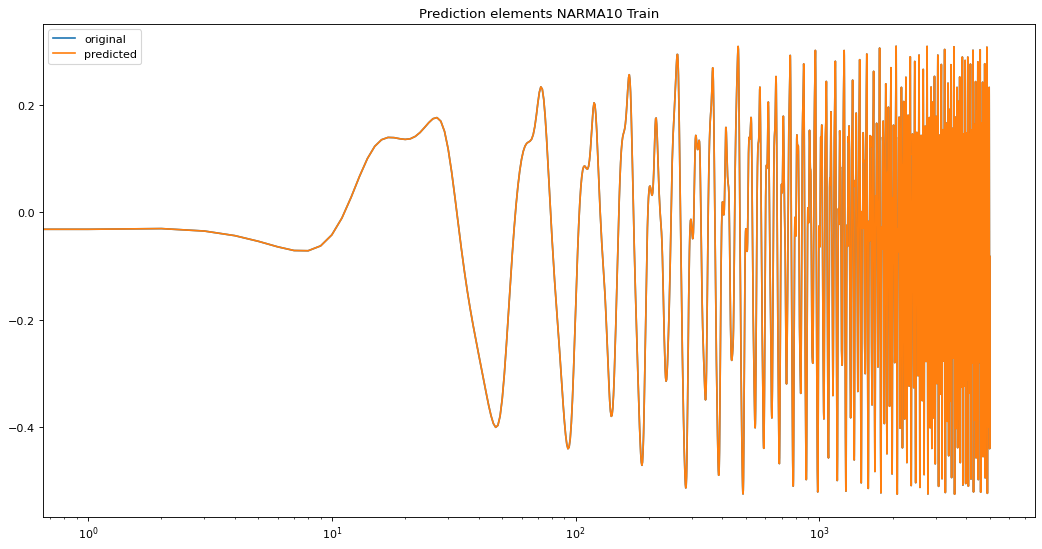

In [ ]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction elements NARMA10 Train")
plt.semilogx(MG17_y[5000:], label="original")
plt.semilogx(y_pred[5000:], label="predicted")
plt.legend()
plt.savefig("Images/MG17_Test_Pred")
plt.show()